In [1]:
import pandas as pd
import json
import numpy as np
import sklearn
import matplotlib.pyplot  as plt
import seaborn as sns
from datetime import datetime, date, time, timedelta
from dateutil.relativedelta import relativedelta

%matplotlib inline
sns.set(style='whitegrid')
pd.set_option('display.float_format', '{:.2f}'.format)

# Configure NumPy to avoid scientific notation
np.set_printoptions(suppress=True, precision=2)

In [2]:
def flatten_json(input_path, output_path):
    with open(input_path, 'r') as infile:
        # Read the entire JSON content
        content = infile.read()
        
        # Load the content as a nested list
        nested_list = json.loads(content)
        
        # Flatten the nested list
        flattened_list = [item for sublist in nested_list for item in sublist]
        
        # Write the flattened JSON to a new file
        with open(output_path, 'w') as outfile:
            json.dump(flattened_list, outfile, indent=4)

# Calling function to flatten the accounts JSON
input_file_path = 'data/train/accounts_data_train.json'
output_file_path = 'data/train/flattened_account_data.json'
# flatten_json(input_file_path, output_file_path)

# Calling function to flatten the enquiry JSON
input_file_path = 'data/train/enquiry_data_train.json'
output_file_path = 'data/train/flattened_enquiry_data.json'
# flatten_json(input_file_path, output_file_path)


In [3]:
#reading the files
account_df = pd.read_json('data/train/flattened_account_data.json')
enquiry_df = pd.read_json('data/train/flattened_enquiry_data.json')
flag_df = pd.read_csv('data/train/train_flag.csv')

In [4]:
# #saving it to csv for manual inspection
# account_df.to_csv('data/train/flattened_account_data.csv', encoding='utf-8', index=False)
# enquiry_df.to_csv('data/train/flattened_enquiry_data.csv', encoding='utf-8', index=False)

In [5]:
print("Size of account table - ",account_df.shape)
print("Size of enquiry table - ",enquiry_df.shape)
print("Size of flag table - ",flag_df.shape)

Size of account table -  (1245310, 7)
Size of enquiry table -  (1909926, 4)
Size of flag table -  (261383, 3)


## Inspecting flag_df 

In [6]:
flag_df.head()

,uid,NAME_CONTRACT_TYPE,TARGET
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0
3,TCQ47571695,Cash loans,0
4,WJZ68772744,Cash loans,0


In [7]:
flag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   uid                 261383 non-null  object
 1   NAME_CONTRACT_TYPE  261383 non-null  object
 2   TARGET              261383 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.0+ MB


In [8]:
flag_df.isna().sum()

uid                   0
NAME_CONTRACT_TYPE    0
TARGET                0
dtype: int64

In [9]:
flag_df.duplicated().sum()

0

In [10]:
flag_df['uid'].nunique()

261383

In [11]:
flag_df['NAME_CONTRACT_TYPE'].unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

Text(0.5, 1.0, 'Frequency of what type of loan people took ?')

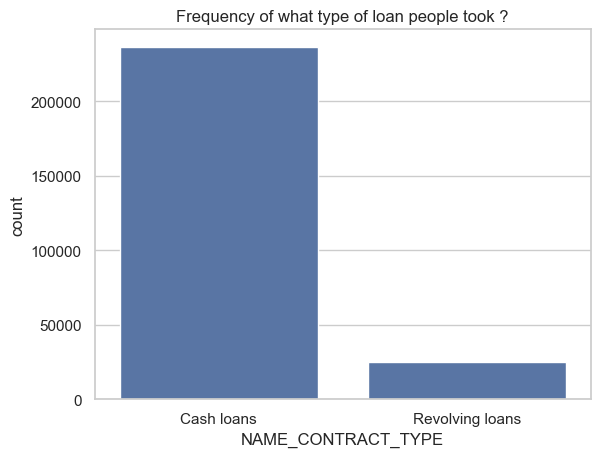

In [12]:
sns.countplot(data=flag_df,x='NAME_CONTRACT_TYPE')
plt.title('Frequency of what type of loan people took ?')

In [13]:
flag_df['TARGET'].value_counts()

TARGET
0    240326
1     21057
Name: count, dtype: int64

In [14]:
flag_df['TARGET'].value_counts()*100/flag_df['TARGET'].value_counts().sum()

TARGET
0   91.94
1    8.06
Name: count, dtype: float64

Text(0.5, 1.0, 'Frequency of loan default(1) and no default(0)')

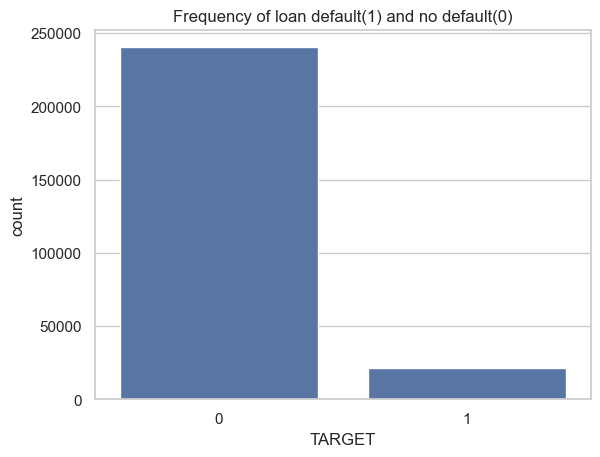

In [15]:
sns.countplot(data=flag_df,x='TARGET')
plt.title('Frequency of loan default(1) and no default(0)')

In [16]:
cash_loan_df = flag_df[flag_df['NAME_CONTRACT_TYPE'] == "Cash loans"]
revolving_loan_df = flag_df[flag_df['NAME_CONTRACT_TYPE'] == "Revolving loans"]

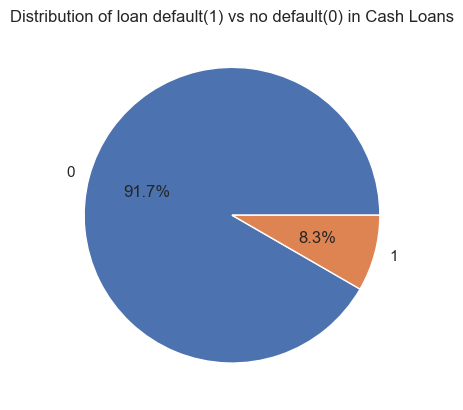

In [17]:
plt.pie(cash_loan_df['TARGET'].value_counts(), labels = cash_loan_df['TARGET'].value_counts().index, autopct="%0.1f%%")
plt.title('Distribution of loan default(1) vs no default(0) in Cash Loans')
plt.show()

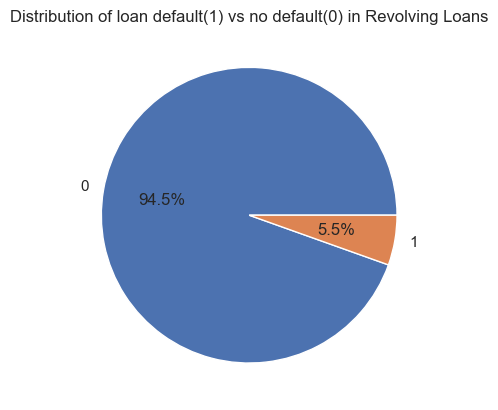

In [18]:
plt.pie(revolving_loan_df['TARGET'].value_counts(), labels = revolving_loan_df['TARGET'].value_counts().index, autopct="%0.1f%%")
plt.title('Distribution of loan default(1) vs no default(0) in Revolving Loans')
plt.show()

``` Inference ```
- Data has 261383 rows and 3 columns
- No null values
- No duplicates
- - Cash Loans: A fixed-amount loan repaid in regular installments over a set period. Eg. home loan, education loan
     - Revolving Loans: A flexible credit line allowing borrowing up to a limit, with variable repayments based on the outstanding balance. Eg. credit card
- Most people take cash loans
- Data is highly imbalanced - 92% is good loan (0) and 8% is bad loan (1) !

Preparing final dataset

In [19]:
final_df = flag_df.copy()

In [20]:
final_df = final_df.rename(columns={'NAME_CONTRACT_TYPE':'applied_contract_type','TARGET':'target'})
final_df.head()

,uid,applied_contract_type,target
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0
3,TCQ47571695,Cash loans,0
4,WJZ68772744,Cash loans,0


In [21]:
final_df.shape

(261383, 3)

## Inspecting account_df 

In [22]:
account_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.00,0.00,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.00,0.00,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.45,0.00,2020-06-29,None,000000000000000000,AAA10545297
3,Consumer credit,43771.50,0.00,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.50,0.00,2014-09-10,None,0000000000000000000000000000000000000000000000...,AAA20326915


In [23]:
account_df.shape

(1245310, 7)

In [24]:
account_df.duplicated().sum()

6411

In [25]:
#removing duplicates
account_df = account_df.drop_duplicates(keep='first')
account_df.shape

(1238899, 7)

In [26]:
account_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1238899 entries, 0 to 1245309
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   credit_type          1238899 non-null  object 
 1   loan_amount          1238896 non-null  float64
 2   amount_overdue       1238899 non-null  float64
 3   open_date            1238899 non-null  object 
 4   closed_date          779803 non-null   object 
 5   payment_hist_string  1238899 non-null  object 
 6   uid                  1238899 non-null  object 
dtypes: float64(2), object(5)
memory usage: 75.6+ MB


It seems 3 loan_amount values are nan, let's check

In [27]:
account_df[account_df['loan_amount'].isna()]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
65605,Another type of loan,NaN,0.00,2021-01-01,2020-10-21,,BJV01354901
149202,Another type of loan,NaN,0.00,2021-01-01,None,,DCX71532515
613183,Another type of loan,NaN,0.00,2021-01-01,None,,MVG95017452


Removing 3 rows where loan_amount is nan

In [28]:
account_df = account_df.dropna(subset='loan_amount')

In [29]:
account_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1238896 entries, 0 to 1245309
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   credit_type          1238896 non-null  object 
 1   loan_amount          1238896 non-null  float64
 2   amount_overdue       1238896 non-null  float64
 3   open_date            1238896 non-null  object 
 4   closed_date          779802 non-null   object 
 5   payment_hist_string  1238896 non-null  object 
 6   uid                  1238896 non-null  object 
dtypes: float64(2), object(5)
memory usage: 75.6+ MB


In [30]:
account_df['open_date'] = pd.to_datetime(account_df['open_date'])
account_df['closed_date'] = pd.to_datetime(account_df['closed_date'])

In [31]:
account_df.describe()

,loan_amount,amount_overdue,open_date,closed_date
count,1238896.00,1238896.00,1238896,779802
mean,351314.79,42.20,2017-11-15 03:20:10.329195008,2018-03-16 05:42:24.932175872
min,0.00,0.00,2013-01-01 00:00:00,1905-12-13 00:00:00
25%,51223.46,0.00,2016-06-07 00:00:00,2016-11-22 00:00:00
50%,124317.00,0.00,2018-04-23 00:00:00,2018-07-18 00:00:00
75%,306450.00,0.00,2019-09-20 00:00:00,2019-11-02 00:00:00
max,396000000.00,3756681.00,2021-01-01 00:00:00,2021-01-01 00:00:00
std,1095943.84,6685.78,NaN,NaN


#### Working on loan_amount column

4 issues - 
- Minimum closed_date year is 1905 which looks absurd. 
- Closed date is less than open date for some, which is not possible
- minimum loan amount is 0 which means either data not known or present.
- Maximum loan amount is of 39 crores !!!

<Axes: ylabel='loan_amount'>

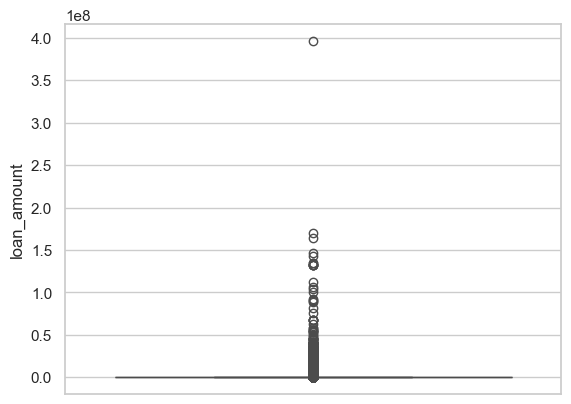

In [32]:
sns.boxplot(account_df['loan_amount'])

Checking who took 39 crores worth of loan :)

In [33]:
account_df.sort_values('loan_amount', ascending = False).head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
281371,Consumer credit,396000000.00,0.00,2013-02-25,2013-04-03,000,FVT19066952
563503,Consumer credit,170100000.00,0.00,2018-04-01,NaT,0000000000000000000000000000000000000000000000...,LUJ95553881
563491,Consumer credit,164032200.00,0.00,2017-12-01,NaT,0000000000000000000000000000000000000000000000...,LUJ95553881
429984,Loan for business development,146958507.00,0.00,2013-04-09,2013-12-27,000000000000000000000000,IYO09389415
256648,Mortgage,142290000.00,0.00,2014-07-27,2018-01-27,0000000000000000000000000000000190490791091391...,FIQ93565046


In [34]:
account_df[account_df['uid']=='FVT19066952']

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
281371,Consumer credit,396000000.00,0.00,2013-02-25,2013-04-03,000,FVT19066952
281372,Consumer credit,144688.50,0.00,2019-08-26,2019-10-12,000,FVT19066952


This person repayed 39 crores loan in 2 months in 2013. In 2019 took loan of 1.4 lakhs. Might have gone bankrupt in 2019.

In [35]:
account_df.drop([281371,281372],inplace=True)

In [36]:
account_df['loan_amount'].describe()

count     1238894.00
mean       350995.60
std       1036697.48
min             0.00
25%         51223.36
50%        124317.00
75%        306445.50
max     170100000.00
Name: loan_amount, dtype: float64

Chcecking loan taken before 2013

In [37]:
account_df[account_df['closed_date'].dt.year<2013]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
380416,Consumer credit,711450.00,0.00,2018-03-17,2012-09-03,,HXU23242159
752854,Credit card,225000.00,0.00,2014-08-06,1905-12-13,,PSI76661644


Checking loan which has open_date > close_date and removing them

In [38]:
account_df[account_df['closed_date'].dt.date<account_df['open_date'].dt.date]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
91932,Consumer credit,153000.00,0.00,2019-07-08,2019-06-17,,BXW18347652
143642,Consumer credit,450000.00,0.00,2017-05-27,2017-04-14,,CZP89943956
147697,Consumer credit,360000.00,0.00,2013-06-05,2013-03-14,,DBX47652567
212896,Credit card,675000.00,0.00,2019-03-27,2015-11-29,,ELL49792531
380416,Consumer credit,711450.00,0.00,2018-03-17,2012-09-03,,HXU23242159
642848,Mortgage,2250000.00,0.00,2017-03-12,2013-10-18,,NLJ87108009
664086,Consumer credit,93564.00,0.00,2017-06-02,2016-12-02,,NWS78995671
752854,Credit card,225000.00,0.00,2014-08-06,1905-12-13,,PSI76661644
920889,Consumer credit,1350000.00,0.00,2018-07-29,2018-02-04,,TFK88667051
941309,Consumer credit,157500.00,0.00,2015-11-22,2015-10-09,,TQK82834352


Removing these entries

In [39]:
remove_wrong_dates = account_df[account_df['closed_date'].dt.date<account_df['open_date'].dt.date].index
account_df = account_df.drop(remove_wrong_dates)
account_df.shape

(1238882, 7)

Entries where loan_amount is 0

In [40]:
loan_amt_zero = account_df[account_df['loan_amount']==0]
loan_amt_zero

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
6,Credit card,0.00,0.00,2014-09-10,2018-08-30,0000000000000000000000000000000000000000000000...,AAA20326915
65,Credit card,0.00,0.00,2019-06-11,2020-04-30,000000000000000000000000000000,AAB67762691
89,Credit card,0.00,0.00,2018-06-27,NaT,0000000000000000000000000000000000000000000000...,AAC13959291
134,Credit card,0.00,0.00,2019-08-20,NaT,000000000000000000000000000000000000000000000000,AAD16503034
150,Credit card,0.00,0.00,2020-10-03,NaT,000000000,AAD30276592
...,...,...,...,...,...,...,...
1245235,Credit card,0.00,0.00,2019-03-11,NaT,0000000000000000000000000000000000000000000000...,ZZY92445865
1245236,Credit card,0.00,0.00,2018-08-22,NaT,0000000000000000000000000000000000000000000000...,ZZY92445865
1245252,Credit card,0.00,0.00,2018-07-02,2019-01-31,000000000000000000000,ZZZ16844313
1245268,Credit card,0.00,0.00,2014-05-22,2018-05-31,0000000000000000000000000000000000000000000000...,ZZZ61418034


In [41]:
account_df.drop(loan_amt_zero.index, inplace=True)

In [42]:
account_df.shape

(1192805, 7)

In [43]:
account_df.sort_values(['loan_amount']).tail(20)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
874694,Consumer credit,81900000.00,0.00,2013-01-19,2013-02-23,000,SGO86800192
874697,Consumer credit,88200000.00,0.00,2013-01-21,2013-02-24,000,SGO86800192
55166,Credit card,90000000.00,0.00,2019-03-06,2019-10-06,000000000000000000000,BEF63017336
542408,Mortgage,90513180.00,0.00,2018-02-04,NaT,0000000000000000000000000000000000000000000000...,LIU65861357
610013,Mortgage,92070000.00,0.00,2014-08-21,NaT,0040000000000000000000000000000000000000000000...,MTN21388722
542407,Mortgage,100998000.00,0.00,2014-02-25,2018-02-11,0000000000000000000000000000000000000000000000...,LIU65861357
629164,Car loan,103500000.00,0.00,2014-04-06,NaT,0000000000000000000000000000000000000000000000...,NDX38466878
904275,Mortgage,106745400.00,0.00,2013-10-15,2018-02-15,0000000000000000000000000000000000000000000000...,SWV90354812
932097,Loan for business development,112500000.00,0.00,2018-09-09,NaT,0000000000000000000000000000000000000000000000...,TLM98385447
874707,Consumer credit,132750000.00,0.00,2013-01-19,2013-02-23,000,SGO86800192


``` Findings ```
- There is a need to verify above data because for a few of the user ID loan of almost same amount is given in interval of just few days which looks suspecious. Maybe the date would be wrong or maybe the record was noted twice - with and without taxes or something along these lines.
-  user SGO86800192 has 5 entries of same amount with a week of each other. I will remove 4 of these entries.

In [44]:
duplicate_index = [874704,874698,874696,874695]
account_df.drop(duplicate_index, inplace=True)
account_df.shape

(1192801, 7)

<Axes: ylabel='loan_amount'>

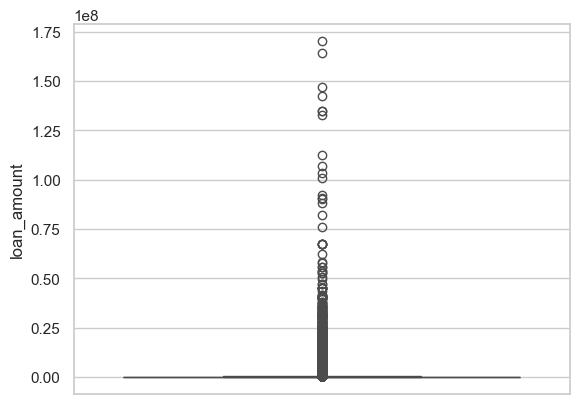

In [45]:
sns.boxplot(account_df['loan_amount'])

<Axes: xlabel='loan_amount', ylabel='amount_overdue'>

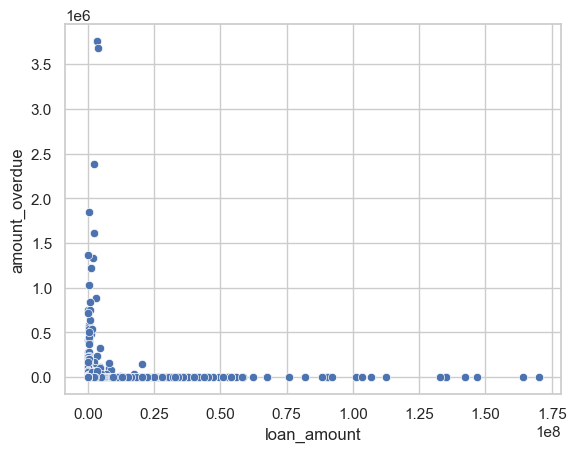

In [46]:
sns.scatterplot(account_df, x="loan_amount", y="amount_overdue" )

``` Findings ```
- For where loan_amount is high, almost 0 amount is overdued 
- An interesting finding ! There are cases where the amount_overdue exceeds the loan_amount !! Which is possible only when the person has defaulted many times and accrued interest and fees or the data entry would be wrong.

In [47]:
account_df[account_df['loan_amount']<account_df['amount_overdue']]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
191211,Consumer credit,434250.00,588325.50,2019-10-28,NaT,000000000000000000000000000000000000005035,DZW81172740
258981,Microloan,18000.00,21420.00,2020-10-11,NaT,000009,FKA61003581
265559,Consumer credit,225000.00,413482.50,2017-09-24,NaT,0000000000000000000000000000000000000000000000...,FNR67758375
275169,Consumer credit,16128.00,63949.50,2014-10-03,2017-04-14,0090390690991291591892192492793093393693994294...,FSS21889724
297310,Consumer credit,200340.00,278766.00,2015-07-24,NaT,0000000000000000000000000000000000000000000000...,GEJ44589554
332117,Consumer credit,132214.50,231421.50,2014-03-23,NaT,0000000000000000000000000000000000000000000000...,GXF52309702
340073,Consumer credit,383040.00,1851210.00,2014-11-26,2017-02-15,0090390690991291591892192492793093393693994294...,HBP46998402
378572,Credit card,22500.00,63423.00,2019-10-22,NaT,000000000000000000000000000008038068098128,HWT02083841
393150,Consumer credit,450000.00,742491.00,2014-11-12,NaT,0000000000000000000000000000000000000000000000...,IET57258681
398678,Credit card,477000.00,542034.00,2018-07-04,NaT,0000000000060360660961261561862162462763063363...,IHW05685385


#### Working on uid column

In [48]:
account_df['uid'].nunique()

222989

#### Working on credit_type column

In [49]:
account_df['credit_type'].unique()

array(['Consumer credit', 'Credit card', 'Mortgage', 'Car loan',
       'Loan for business development', 'Microloan',
       'Another type of loan', 'Loan for working capital replenishment',
       'Unknown type of loan', 'Loan for the purchase of equipment',
       'Real estate loan', 'Cash loan (non-earmarked)',
       'Loan for purchase of shares (margin lending)', 'Interbank credit',
       'Mobile operator loan'], dtype=object)

In [50]:
my_index = account_df[(account_df['credit_type']=='Another type of loan') | (account_df['credit_type']=='Unknown type of loan')].index

In [51]:
account_df.loc[my_index]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
1385,Another type of loan,49500.00,0.00,2019-07-24,2020-01-05,000000000000000,AAS17707267
4944,Another type of loan,238500.00,0.00,2017-06-01,2017-09-24,000000000,ACM77341914
5644,Unknown type of loan,225000.00,0.00,2018-07-03,NaT,0000000000270570000000000000000000000000000000...,ACV82598411
10272,Another type of loan,1061354.07,0.00,2018-12-29,NaT,0000000000000000000000000000000000000000000000...,AFG81651202
12783,Unknown type of loan,234000.00,0.00,2013-10-05,2014-09-20,000000000000000000000000000000000,AGP14627561
...,...,...,...,...,...,...,...
1241247,Unknown type of loan,675000.00,0.00,2013-01-29,NaT,0000000000000000000000000000000000000000000000...,ZXT07913185
1242557,Another type of loan,264861.67,0.00,2016-10-14,NaT,0000000000000000000000000000000000000000000000...,ZYL40828164
1243452,Another type of loan,144000.00,0.00,2017-08-15,2018-08-16,000000000000000000000000000000000000,ZYZ05018891
1243531,Unknown type of loan,1350000.00,0.00,2020-08-21,NaT,000000000000,ZYZ85038085


In [52]:
account_df['credit_type'] = account_df['credit_type'].replace(['Another type of loan','Unknown type of loan'],'other_loans')

In [53]:
account_df.loc[my_index]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
1385,other_loans,49500.00,0.00,2019-07-24,2020-01-05,000000000000000,AAS17707267
4944,other_loans,238500.00,0.00,2017-06-01,2017-09-24,000000000,ACM77341914
5644,other_loans,225000.00,0.00,2018-07-03,NaT,0000000000270570000000000000000000000000000000...,ACV82598411
10272,other_loans,1061354.07,0.00,2018-12-29,NaT,0000000000000000000000000000000000000000000000...,AFG81651202
12783,other_loans,234000.00,0.00,2013-10-05,2014-09-20,000000000000000000000000000000000,AGP14627561
...,...,...,...,...,...,...,...
1241247,other_loans,675000.00,0.00,2013-01-29,NaT,0000000000000000000000000000000000000000000000...,ZXT07913185
1242557,other_loans,264861.67,0.00,2016-10-14,NaT,0000000000000000000000000000000000000000000000...,ZYL40828164
1243452,other_loans,144000.00,0.00,2017-08-15,2018-08-16,000000000000000000000000000000000000,ZYZ05018891
1243531,other_loans,1350000.00,0.00,2020-08-21,NaT,000000000000,ZYZ85038085


In [54]:
account_df['credit_type'].value_counts()

credit_type
Consumer credit                                 905002
Credit card                                     244458
Car loan                                         20110
Mortgage                                         13011
Microloan                                         7734
Loan for business development                     1462
other_loans                                        649
Loan for working capital replenishment             319
Real estate loan                                    17
Cash loan (non-earmarked)                           17
Loan for the purchase of equipment                  16
Loan for purchase of shares (margin lending)         4
Interbank credit                                     1
Mobile operator loan                                 1
Name: count, dtype: int64

```Making column - total_tl```

So many categories, let's group then -
1. consumer loan
    - Consumer credit
    - Credit card
    - Cash loan (non-earmarked)
    - Microloan
    - Mobile operator loan
2. Mortgages loan
    - Mortgage
    - Real estate loan
3. automobile loan
    - Car loan
4. business loan
    - Loan for business development
    - Loan for working capital replenishment
    - Loan for the purchase of equipment
    - Loan for purchase of shares (margin lending)
    - Interbank credit
5. other loan

In [55]:
loan_type_mapping = {
    'Consumer credit': 'consumer_loans',
    'Credit card': 'consumer_loans',
    'Mortgage': 'mortgages_and_real_estate_loans',
    'Car loan': 'automobile_loans',
    'Loan for business development': 'business_loans',
    'Microloan': 'consumer_loans',
    'Loan for working capital replenishment': 'business_loans',
    'Loan for the purchase of equipment': 'business_loans',
    'Real estate loan': 'mortgages_and_real_estate_loans',
    'Cash loan (non-earmarked)': 'consumer_loans',
    'Loan for purchase of shares (margin lending)': 'business_loans',
    'Interbank credit': 'business_loans',
    'Mobile operator loan': 'consumer_loans'
}

account_df['credit_type'] = account_df['credit_type'].replace(loan_type_mapping)

account_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,consumer_loans,272745.00,0.00,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,consumer_loans,4500.00,0.00,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,consumer_loans,80996.45,0.00,2020-06-29,NaT,000000000000000000,AAA10545297
3,consumer_loans,43771.50,0.00,2020-06-09,2020-09-09,000000000,AAA14112888
4,consumer_loans,10480.50,0.00,2014-09-10,NaT,0000000000000000000000000000000000000000000000...,AAA20326915


Text(0.5, 1.0, 'Loan amount per credit type')

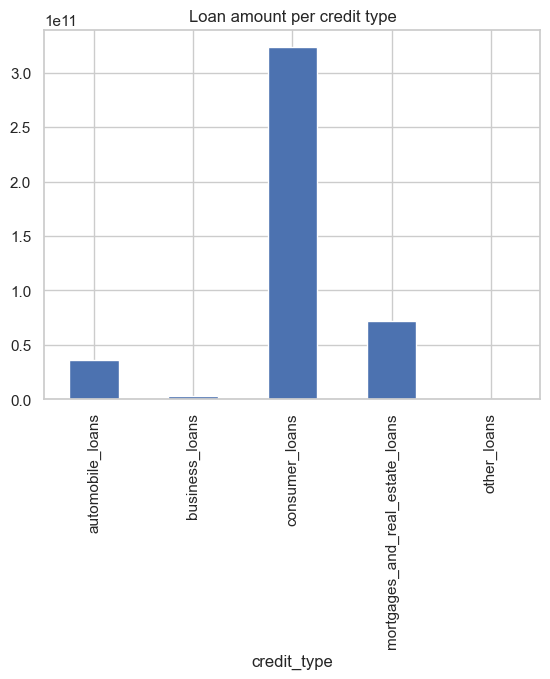

In [56]:
grouped_df = account_df.groupby('credit_type')['loan_amount'].sum()
grouped_df.plot(kind='bar')
plt.title("Loan amount per credit type")

Text(0.5, 1.0, 'No. of Loan taken per credit type')

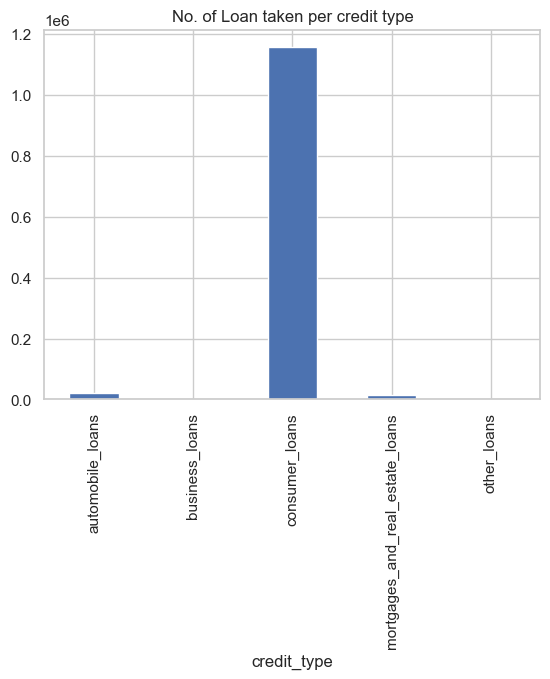

In [57]:
grouped_df = account_df.groupby('credit_type')['loan_amount'].size()
grouped_df.plot(kind='bar')
plt.title("No. of Loan taken per credit type")

<Axes: >

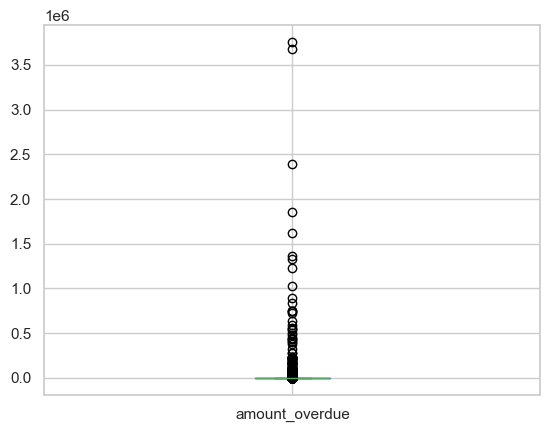

In [58]:
account_df['amount_overdue'].plot(kind='box')

Text(0, 0.5, 'Sum of Loan Amount')

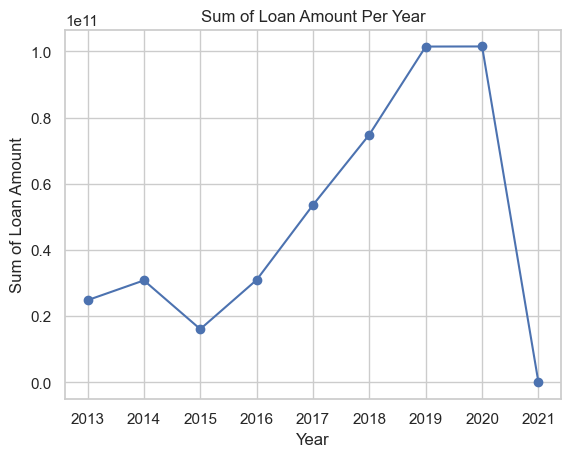

In [59]:
account_df['open_year'] = account_df['open_date'].dt.year
grouped_df = account_df.groupby('open_year')['loan_amount'].sum().reset_index()
plt.plot(grouped_df['open_year'], grouped_df['loan_amount'], marker='o', linestyle='-', color='b')
plt.title('Sum of Loan Amount Per Year')
plt.xlabel('Year')
plt.ylabel('Sum of Loan Amount')

In [60]:
account_df.sort_values(['amount_overdue']).tail(20)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,open_year
1159487,consumer_loans,1449040.50,535122.00,2020-01-04,NaT,000000000000000000025055085115145175,YFJ39780706,2020
398678,consumer_loans,477000.00,542034.00,2018-07-04,NaT,0000000000060360660961261561862162462763063363...,IHW05685385,2018
224778,consumer_loans,585000.00,562233.19,2018-09-06,NaT,0000000000000000000000000000000000000000000000...,ERO99223427,2018
191211,consumer_loans,434250.00,588325.50,2019-10-28,NaT,000000000000000000000000000000000000005035,DZW81172740,2019
480973,consumer_loans,926797.50,634846.50,2019-09-13,NaT,000000000000000000000000019049079109139169199,KAC17126649,2019
943342,consumer_loans,148671.00,721809.00,2014-12-02,2019-03-26,0000000000000000000000000000000000000000000000...,TRO18986832,2014
393150,consumer_loans,450000.00,742491.00,2014-11-12,NaT,0000000000000000000000000000000000000000000000...,IET57258681,2014
479310,consumer_loans,45000.00,746550.00,2019-06-15,NaT,0100400701001301601902202502803103403704004304...,JZG40975784,2019
734259,consumer_loans,899307.00,748863.00,2018-04-28,NaT,0000000000000000000000000000000000000000000000...,PIT60018621,2018
1159486,consumer_loans,900000.00,837193.50,2019-05-11,NaT,0000000000000000000000000000000000000000000180...,YFJ39780706,2019


``` Making Total_tl feature ```

In [61]:
temp_df = account_df.groupby('uid').size().reset_index()
temp_df

,uid,0
0,AAA09044550,2
1,AAA10545297,1
2,AAA14112888,1
3,AAA20326915,7
4,AAA31604840,5
...,...,...
222984,ZZZ74526004,3
222985,ZZZ78449185,7
222986,ZZZ79008454,3
222987,ZZZ81253108,4


In [62]:
final_df = final_df.merge(temp_df, on ='uid', how='left')

In [63]:
final_df = final_df.rename(columns={0:'total_tl'})
final_df.head()

,uid,applied_contract_type,target,total_tl
0,XDA69787158,Cash loans,0,1.00
1,BSE47789733,Cash loans,0,1.00
2,NTJ92213825,Cash loans,0,1.00
3,TCQ47571695,Cash loans,0,3.00
4,WJZ68772744,Cash loans,0,NaN


In [64]:
final_df.shape

(261383, 4)

``` Making closed TL and active TL columns```

In [65]:
temp_df = account_df[~account_df['closed_date'].isna()].groupby('uid').size().reset_index()
temp_df

,uid,0
0,AAA09044550,2
1,AAA14112888,1
2,AAA20326915,4
3,AAA31604840,2
4,AAA54240429,1
...,...,...
194142,ZZZ74526004,3
194143,ZZZ78449185,7
194144,ZZZ79008454,1
194145,ZZZ81253108,1


In [66]:
final_df = final_df.merge(temp_df, on ='uid', how='left')
final_df = final_df.rename(columns={0:'complete_tl'})
final_df['active_tl'] = final_df['total_tl']-final_df['complete_tl']
final_df.head()

,uid,applied_contract_type,target,total_tl,complete_tl,active_tl
0,XDA69787158,Cash loans,0,1.00,NaN,NaN
1,BSE47789733,Cash loans,0,1.00,1.00,0.00
2,NTJ92213825,Cash loans,0,1.00,1.00,0.00
3,TCQ47571695,Cash loans,0,3.00,2.00,1.00
4,WJZ68772744,Cash loans,0,NaN,NaN,NaN


In [67]:
final_df.shape

(261383, 6)

``` Making total_amount_overdue, average_loan_amount, max_loan_amount and min_loan_amount columns ```

In [68]:
aggregated_df  = account_df.groupby('uid').agg({'amount_overdue':'sum','loan_amount': ['mean', 'min', 'max']}).reset_index()
aggregated_df.columns = ['uid', 'amount_overdue_sum', 'loan_amount_avg', 'loan_amount_min', 'loan_amount_max']
aggregated_df

,uid,amount_overdue_sum,loan_amount_avg,loan_amount_min,loan_amount_max
0,AAA09044550,0.00,138622.50,4500.00,272745.00
1,AAA10545297,0.00,80996.45,80996.45,80996.45
2,AAA14112888,0.00,43771.50,43771.50,43771.50
3,AAA20326915,0.00,84513.86,10480.50,235800.00
4,AAA31604840,0.00,318392.10,41845.50,687150.00
...,...,...,...,...,...
222984,ZZZ74526004,0.00,37864.50,17505.00,59940.00
222985,ZZZ78449185,0.00,92834.36,40455.00,195210.00
222986,ZZZ79008454,127260.00,1672021.50,170914.50,3375000.00
222987,ZZZ81253108,0.00,1334430.00,121500.00,2529720.00


In [69]:
final_df = pd.merge(final_df, aggregated_df, on='uid', how='left')

In [70]:
final_df.head()

,uid,applied_contract_type,target,total_tl,complete_tl,active_tl,amount_overdue_sum,loan_amount_avg,loan_amount_min,loan_amount_max
0,XDA69787158,Cash loans,0,1.00,NaN,NaN,0.00,450000.00,450000.00,450000.00
1,BSE47789733,Cash loans,0,1.00,1.00,0.00,0.00,110155.50,110155.50,110155.50
2,NTJ92213825,Cash loans,0,1.00,1.00,0.00,0.00,103783.50,103783.50,103783.50
3,TCQ47571695,Cash loans,0,3.00,2.00,1.00,0.00,224292.00,63351.00,450000.00
4,WJZ68772744,Cash loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
final_df.shape

(261383, 10)

``` Making num_times_delinquent column ```

In [72]:
account_df = account_df.reset_index(drop=True)

In [73]:
def calculate_payment_features(hist_string):
    segments = [int(hist_string[i:i+3]) for i in range(0, len(hist_string), 3)]
    # Calculate total deliquent payment (no. of months with any overdue days)
    num_times_delinquent = len([days for days in segments if days > 0])
    
    return num_times_delinquent

account_df['num_times_delinquent'] = account_df['payment_hist_string'].apply(calculate_payment_features)
account_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,open_year,num_times_delinquent
0,consumer_loans,272745.00,0.00,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550,2018,1
1,consumer_loans,4500.00,0.00,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550,2018,2
2,consumer_loans,80996.45,0.00,2020-06-29,NaT,000000000000000000,AAA10545297,2020,0
3,consumer_loans,43771.50,0.00,2020-06-09,2020-09-09,000000000,AAA14112888,2020,0
4,consumer_loans,10480.50,0.00,2014-09-10,NaT,0000000000000000000000000000000000000000000000...,AAA20326915,2014,31


In [74]:
deliquent_df = account_df.groupby('uid')['num_times_delinquent'].sum()

In [75]:
final_df.shape

(261383, 10)

In [76]:
final_df = pd.merge(final_df, deliquent_df, on='uid', how='left')

In [77]:
final_df.shape

(261383, 11)

In [78]:
final_df.sample(10)

,uid,applied_contract_type,target,total_tl,complete_tl,active_tl,amount_overdue_sum,loan_amount_avg,loan_amount_min,loan_amount_max,num_times_delinquent
240707,LLV25215078,Cash loans,0,15.00,10.00,5.00,0.00,1552080.00,63000.00,4027500.00,11.00
137315,EXK87666402,Cash loans,0,14.00,9.00,5.00,4.50,267440.14,27000.00,1350000.00,1.00
225744,MUV32465238,Revolving loans,0,1.00,NaN,NaN,0.00,396000.00,396000.00,396000.00,0.00
24827,JVQ19495181,Cash loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124278,RIR78983599,Cash loans,0,3.00,2.00,1.00,0.00,618378.00,109134.00,900000.00,0.00
90035,OJP63427468,Cash loans,0,2.00,NaN,NaN,0.00,202500.00,45000.00,360000.00,0.00
201879,LGT55366968,Cash loans,0,3.00,1.00,2.00,0.00,4581360.00,34830.00,13500000.00,0.00
51406,LRV78007301,Cash loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140958,GDS80443286,Cash loans,0,4.00,1.00,3.00,0.00,247783.50,48834.00,392400.00,3.00
251531,JLI72961414,Cash loans,0,3.00,2.00,1.00,0.00,838171.50,148378.50,2214000.00,0.00


``` Making time since recent deliquency column ```

In [79]:
def find_recent_delinquency_date(hist_string, open_date):
    segments = [int(hist_string[i:i+3]) for i in range(0, len(hist_string), 3)]
    
    # Calculate time since recent delinquency
    recent_delinquency_index = None
    for i, days in enumerate(reversed(segments)):
        if days > 0:
            recent_delinquency_index = len(segments) - 1 - i
            break
    
    if recent_delinquency_index == None:
        time_since_recent_delinquency = None  # No delinquency found
    else:
        months_ago = len(segments) - 1 - recent_delinquency_index
        delinquency_date = open_date + relativedelta(months=months_ago)        

        return delinquency_date

def months_since_date(past_date):
    if pd.isna(past_date):
        return 0  # Return 0 if there is no delinquency
    today = datetime.today()
    diff = relativedelta(today, past_date)
    return diff.years * 12 + diff.months


account_df['recent_delinquency_date'] = account_df.apply(lambda row: find_recent_delinquency_date(row['payment_hist_string'], row['open_date']), axis=1)
account_df['months_since_recent_delinquency'] = account_df['recent_delinquency_date'].apply(months_since_date)

account_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,open_year,num_times_delinquent,recent_delinquency_date,months_since_recent_delinquency
0,consumer_loans,272745.00,0.00,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550,2018,1,2019-06-22,62
1,consumer_loans,4500.00,0.00,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550,2018,2,2018-12-08,68
2,consumer_loans,80996.45,0.00,2020-06-29,NaT,000000000000000000,AAA10545297,2020,0,NaT,0
3,consumer_loans,43771.50,0.00,2020-06-09,2020-09-09,000000000,AAA14112888,2020,0,NaT,0
4,consumer_loans,10480.50,0.00,2014-09-10,NaT,0000000000000000000000000000000000000000000000...,AAA20326915,2014,31,2015-01-10,115


In [80]:
account_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,open_year,num_times_delinquent,recent_delinquency_date,months_since_recent_delinquency
0,consumer_loans,272745.00,0.00,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550,2018,1,2019-06-22,62
1,consumer_loans,4500.00,0.00,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550,2018,2,2018-12-08,68
2,consumer_loans,80996.45,0.00,2020-06-29,NaT,000000000000000000,AAA10545297,2020,0,NaT,0
3,consumer_loans,43771.50,0.00,2020-06-09,2020-09-09,000000000,AAA14112888,2020,0,NaT,0
4,consumer_loans,10480.50,0.00,2014-09-10,NaT,0000000000000000000000000000000000000000000000...,AAA20326915,2014,31,2015-01-10,115


In [81]:
time_since_recent_deliquency_df = account_df.groupby('uid')['months_since_recent_delinquency'].min()

In [82]:
final_df.shape

(261383, 11)

In [83]:
final_df = pd.merge(final_df, time_since_recent_deliquency_df, on='uid', how='left')

In [84]:
final_df.shape

(261383, 12)

In [85]:
final_df.sample(10)

,uid,applied_contract_type,target,total_tl,complete_tl,active_tl,amount_overdue_sum,loan_amount_avg,loan_amount_min,loan_amount_max,num_times_delinquent,months_since_recent_delinquency
257357,CLR09149492,Cash loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18927,YJH85699565,Cash loans,0,4.00,1.00,3.00,0.00,162855.00,22500.00,445500.00,2.00,0.00
140809,IGF28578568,Cash loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40098,ZTU90118976,Cash loans,0,1.00,1.00,0.00,0.00,125991.00,125991.00,125991.00,0.00,0.00
191801,YFT28617905,Cash loans,0,4.00,4.00,0.00,0.00,277593.75,180000.00,508500.00,0.00,0.00
203592,GBY92606056,Cash loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23936,IMH10472723,Cash loans,0,2.00,1.00,1.00,0.00,239958.00,142416.00,337500.00,0.00,0.00
63147,VSU42566069,Cash loans,0,3.00,2.00,1.00,0.00,858783.00,163174.50,2250000.00,0.00,0.00
236583,EIA95285321,Cash loans,0,11.00,10.00,1.00,0.00,198602.35,20209.50,747450.00,2.00,0.00
136090,SJV12071523,Cash loans,0,1.00,NaN,NaN,0.00,675000.00,675000.00,675000.00,0.00,0.00


```Constructing frequency of each credit_type columns ```

In [86]:
for_pivot_df = account_df[['uid','credit_type']]
x = pd.pivot_table(for_pivot_df,index='uid',columns='credit_type',aggfunc='size', fill_value=0)
x.reset_index(inplace=True)
x

credit_type,uid,automobile_loans,business_loans,consumer_loans,mortgages_and_real_estate_loans,other_loans
0,AAA09044550,0,0,2,0,0
1,AAA10545297,0,0,1,0,0
2,AAA14112888,0,0,1,0,0
3,AAA20326915,0,0,7,0,0
4,AAA31604840,0,0,5,0,0
...,...,...,...,...,...,...
222984,ZZZ74526004,0,0,3,0,0
222985,ZZZ78449185,0,0,7,0,0
222986,ZZZ79008454,0,0,3,0,0
222987,ZZZ81253108,1,0,3,0,0


In [87]:
automobie_loan_count = x.groupby('uid')['automobile_loans'].sum()
business_loan_count = x.groupby('uid')['business_loans'].sum()
consumer_loan_count = x.groupby('uid')['consumer_loans'].sum()
real_estate_loan_count = x.groupby('uid')['mortgages_and_real_estate_loans'].sum()
other_loan_count = x.groupby('uid')['other_loans'].sum()

In [88]:
final_df = pd.merge(final_df, automobie_loan_count, on='uid', how='left')
final_df = pd.merge(final_df, business_loan_count, on='uid', how='left')
final_df = pd.merge(final_df, consumer_loan_count, on='uid', how='left')
final_df = pd.merge(final_df, real_estate_loan_count, on='uid', how='left')
final_df = pd.merge(final_df, other_loan_count, on='uid', how='left')

print(final_df.shape)

(261383, 17)


In [89]:
final_df.head()

,uid,applied_contract_type,target,total_tl,complete_tl,active_tl,amount_overdue_sum,loan_amount_avg,loan_amount_min,loan_amount_max,num_times_delinquent,months_since_recent_delinquency,automobile_loans,business_loans,consumer_loans,mortgages_and_real_estate_loans,other_loans
0,XDA69787158,Cash loans,0,1.00,NaN,NaN,0.00,450000.00,450000.00,450000.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1,BSE47789733,Cash loans,0,1.00,1.00,0.00,0.00,110155.50,110155.50,110155.50,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,NTJ92213825,Cash loans,0,1.00,1.00,0.00,0.00,103783.50,103783.50,103783.50,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,TCQ47571695,Cash loans,0,3.00,2.00,1.00,0.00,224292.00,63351.00,450000.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00
4,WJZ68772744,Cash loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


``` Inference ```
- Data has 1245310 rows but 3 had loan_amount as nan so removed them
- Data has 7 columns
- credit_type - replace mapping 
- removed outlier - 1905 year from closed_date
- removed entries where closing_date < opening_date
- 47,585 rows were removed as they had 0 in loan_amount
- Removed some miswritten or duplicate entries
- For where loan_amount is high, almost 0 amount is overdued 
- Most loans taken were consumer_loans
- made features like total_tl, complete_tl, active_tl
- Closed date is less than open date for some, which is not possible, so removing such entries
- created features - total_amount_overdue, average_loan_amount, num_times_delinquent, time since recent deliquency
- Created features - frequency of each credit_type

## Inspecting enquiry_df 

In [90]:
enquiry_df.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


In [91]:
enquiry_df['enquiry_date'] = pd.to_datetime(enquiry_df['enquiry_date'])

In [92]:
enquiry_df.describe()

,enquiry_amt,enquiry_date
count,1909926.00,1909926
mean,116042.27,2020-03-03 02:34:49.536035328
min,1007.00,2015-08-30 00:00:00
25%,56000.00,2019-10-20 00:00:00
50%,108000.00,2020-05-14 00:00:00
75%,159000.00,2020-09-24 00:00:00
max,499995.00,2021-01-01 00:00:00
std,82070.31,NaN


In [93]:
enquiry_df.sort_values(['enquiry_amt']).head(400)

,enquiry_type,enquiry_amt,enquiry_date,uid
1259509,Cash loans,1007,2020-05-02,RCT52278690
305588,Loan for the purchase of equipment,1010,2020-10-12,EEX35591642
1416733,Cash loans,1018,2020-06-10,TGX96377035
421234,Cash loan (non-earmarked),1018,2020-10-28,FSW73151740
1701664,Real estate loan,1019,2021-01-01,XEE45807925
...,...,...,...,...
462306,Credit card,2053,2019-07-23,GHA55010042
415476,Revolving loans,2057,2020-02-15,FQX21893941
1084259,Revolving loans,2057,2019-10-31,OSU09506253
1750921,Cash loan (non-earmarked),2058,2020-10-05,XVV67233720


In [94]:
enquiry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909926 entries, 0 to 1909925
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   enquiry_type  object        
 1   enquiry_amt   int64         
 2   enquiry_date  datetime64[ns]
 3   uid           object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 58.3+ MB


In [95]:
enquiry_df.isna().sum()

enquiry_type    0
enquiry_amt     0
enquiry_date    0
uid             0
dtype: int64

In [96]:
enquiry_df.duplicated().sum()

9

In [97]:
enquiry_df = enquiry_df.drop_duplicates()

In [98]:
enquiry_df.shape

(1909917, 4)

Text(0, 0.5, 'Sum of Enquiry Amount')

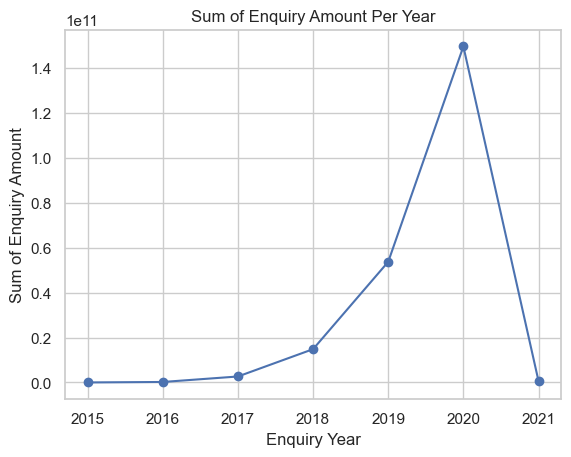

In [99]:
enquiry_df['enquiry_year'] = enquiry_df['enquiry_date'].dt.year
grouped_df = enquiry_df.groupby('enquiry_year')['enquiry_amt'].sum().reset_index()
plt.plot(grouped_df['enquiry_year'], grouped_df['enquiry_amt'], marker='o', linestyle='-', color='b')
plt.title('Sum of Enquiry Amount Per Year')
plt.xlabel('Enquiry Year')
plt.ylabel('Sum of Enquiry Amount')

``` enquery_count and max_enquery_amount ```

In [100]:
aggregated_df  = enquiry_df.groupby('uid').agg({'enquiry_type':'count','enquiry_amt':'max'}).reset_index()
aggregated_df

,uid,enquiry_type,enquiry_amt
0,AAA08065248,11,364751
1,AAA09044550,26,197000
2,AAA10545297,14,192000
3,AAA14112888,15,185000
4,AAA20326915,1,66000
...,...,...,...
261378,ZZZ74526004,8,196000
261379,ZZZ78449185,6,497141
261380,ZZZ79008454,1,28000
261381,ZZZ81253108,29,199000


In [101]:
aggregated_df.rename(columns={'enquiry_type': 'enquiry_count', 'enquiry_amt': 'max_enquiry_amount'}, inplace=True)
final_df = pd.merge(final_df, aggregated_df, on='uid', how='left')
final_df.head()

,uid,applied_contract_type,target,total_tl,complete_tl,active_tl,amount_overdue_sum,loan_amount_avg,loan_amount_min,loan_amount_max,num_times_delinquent,months_since_recent_delinquency,automobile_loans,business_loans,consumer_loans,mortgages_and_real_estate_loans,other_loans,enquiry_count,max_enquiry_amount
0,XDA69787158,Cash loans,0,1.00,NaN,NaN,0.00,450000.00,450000.00,450000.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,2,166000
1,BSE47789733,Cash loans,0,1.00,1.00,0.00,0.00,110155.50,110155.50,110155.50,0.00,0.00,0.00,0.00,1.00,0.00,0.00,3,151000
2,NTJ92213825,Cash loans,0,1.00,1.00,0.00,0.00,103783.50,103783.50,103783.50,0.00,0.00,0.00,0.00,1.00,0.00,0.00,4,167000
3,TCQ47571695,Cash loans,0,3.00,2.00,1.00,0.00,224292.00,63351.00,450000.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,1,148000
4,WJZ68772744,Cash loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,194000


``` time_since_recent_enquiry ```

In [102]:
latest_enquiry_dates = enquiry_df.groupby('uid')['enquiry_date'].max().reset_index()
latest_enquiry_dates

,uid,enquiry_date
0,AAA08065248,2020-12-30
1,AAA09044550,2020-12-29
2,AAA10545297,2020-10-29
3,AAA14112888,2020-07-05
4,AAA20326915,2020-08-14
...,...,...
261378,ZZZ74526004,2020-08-02
261379,ZZZ78449185,2020-12-11
261380,ZZZ79008454,2020-08-31
261381,ZZZ81253108,2020-12-25


In [103]:
current_date = pd.Timestamp(datetime.now()) #present date
latest_enquiry_dates['time_since_last_enquiry'] = (current_date - latest_enquiry_dates['enquiry_date']).dt.days//30
latest_enquiry_dates.head()

,uid,enquiry_date,time_since_last_enquiry
0,AAA08065248,2020-12-30,44
1,AAA09044550,2020-12-29,44
2,AAA10545297,2020-10-29,46
3,AAA14112888,2020-07-05,50
4,AAA20326915,2020-08-14,49


In [104]:
latest_enquiry_dates_tomerge = latest_enquiry_dates[['uid','time_since_last_enquiry']]
final_df = pd.merge(final_df, latest_enquiry_dates_tomerge, on='uid', how='left')
final_df.head()

,uid,applied_contract_type,target,total_tl,complete_tl,active_tl,amount_overdue_sum,loan_amount_avg,loan_amount_min,loan_amount_max,num_times_delinquent,months_since_recent_delinquency,automobile_loans,business_loans,consumer_loans,mortgages_and_real_estate_loans,other_loans,enquiry_count,max_enquiry_amount,time_since_last_enquiry
0,XDA69787158,Cash loans,0,1.00,NaN,NaN,0.00,450000.00,450000.00,450000.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,2,166000,49
1,BSE47789733,Cash loans,0,1.00,1.00,0.00,0.00,110155.50,110155.50,110155.50,0.00,0.00,0.00,0.00,1.00,0.00,0.00,3,151000,46
2,NTJ92213825,Cash loans,0,1.00,1.00,0.00,0.00,103783.50,103783.50,103783.50,0.00,0.00,0.00,0.00,1.00,0.00,0.00,4,167000,48
3,TCQ47571695,Cash loans,0,3.00,2.00,1.00,0.00,224292.00,63351.00,450000.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,1,148000,47
4,WJZ68772744,Cash loans,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,194000,45


``` Frequency of each enquiry type ``` 

enquiry_type has lots of columns so reducing them by clubbing

In [105]:
enquiry_df['enquiry_type'].unique()

array(['Interbank credit', 'Mobile operator loan',
       'Cash loan (non-earmarked)', 'Mortgage', 'Revolving loans',
       'Loan for purchase of shares (margin lending)', 'Cash loans',
       'Car loan', 'Another type of loan',
       'Loan for the purchase of equipment', 'Real estate loan',
       'Credit card', 'Unknown type of loan', 'Microloan',
       'Consumer credit', 'Loan for working capital replenishment',
       'Loan for business development'], dtype=object)

In [106]:
enquiry_type_mapping = {
    'Interbank credit' : 'business_loans_enquiries',
    'Mobile operator loan': 'consumer_loans_enquiries',
    'Cash loan (non-earmarked)': 'consumer_loans_enquiries',
    'Mortgage' : 'mortgages_and_real_estate_loans_enquiries',
    'Loan for purchase of shares (margin lending)': 'business_loans_enquiries',
    'Cash loans': 'consumer_loans_enquiries',
    'Car loan': 'automobile_loans_enquiries',
    'Another type of loan': 'other_loans_enquiries',
    'Loan for the purchase of equipment': 'business_loans_enquiries',
    'Real estate loan': 'mortgages_and_real_estate_loans_enquiries',
    'Credit card': 'consumer_loans_enquiries',
    'Unknown type of loan': 'other_loans_enquiries',
    'Microloan': 'consumer_loans_enquiries',
    'Consumer credit': 'consumer_loans_enquiries',
    'Loan for working capital replenishment': 'business_loans_enquiries',
    'Loan for business development': 'business_loans_enquiries',
    'Revolving loans': 'revolving_loans_enquiries'
}


enquiry_df['enquiry_type'] = enquiry_df['enquiry_type'].replace(enquiry_type_mapping)

In [107]:
enquiry_df['enquiry_type'].unique()

array(['business_loans_enquiries', 'consumer_loans_enquiries',
       'mortgages_and_real_estate_loans_enquiries',
       'revolving_loans_enquiries', 'automobile_loans_enquiries',
       'other_loans_enquiries'], dtype=object)

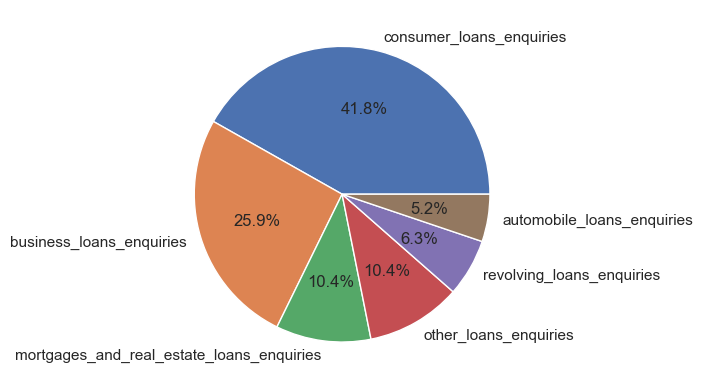

In [108]:
plt.pie(enquiry_df['enquiry_type'].value_counts(),labels = enquiry_df['enquiry_type'].value_counts().index, autopct="%0.1f%%")
plt.show()

In [109]:
for_pivot_df = enquiry_df[['uid','enquiry_type']]
x = pd.pivot_table(for_pivot_df,index='uid',columns='enquiry_type',aggfunc='size', fill_value=0)
x.reset_index(inplace=True)
x

enquiry_type,uid,automobile_loans_enquiries,business_loans_enquiries,consumer_loans_enquiries,mortgages_and_real_estate_loans_enquiries,other_loans_enquiries,revolving_loans_enquiries
0,AAA08065248,0,5,3,1,0,2
1,AAA09044550,3,3,13,2,4,1
2,AAA10545297,0,2,8,0,2,2
3,AAA14112888,0,7,6,0,2,0
4,AAA20326915,0,0,1,0,0,0
...,...,...,...,...,...,...,...
261378,ZZZ74526004,0,3,2,3,0,0
261379,ZZZ78449185,0,2,2,2,0,0
261380,ZZZ79008454,0,0,1,0,0,0
261381,ZZZ81253108,2,9,11,3,2,2


In [110]:
business_loan_count = x.groupby('uid')['business_loans_enquiries'].sum()
consumer_loan_count = x.groupby('uid')['consumer_loans_enquiries'].sum()
revolving_loan_count = x.groupby('uid')['revolving_loans_enquiries'].sum()
real_estate_loan_count = x.groupby('uid')['mortgages_and_real_estate_loans_enquiries'].sum()
other_loan_count = x.groupby('uid')['other_loans_enquiries'].sum()
automobile_loan_count = x.groupby('uid')['automobile_loans_enquiries'].sum()

In [111]:
final_df = pd.merge(final_df, business_loan_count, on='uid', how='left')
final_df = pd.merge(final_df, consumer_loan_count, on='uid', how='left')
final_df = pd.merge(final_df, revolving_loan_count, on='uid', how='left')
final_df = pd.merge(final_df, real_estate_loan_count, on='uid', how='left')
final_df = pd.merge(final_df, other_loan_count, on='uid', how='left')
final_df = pd.merge(final_df, automobile_loan_count, on='uid', how='left')

print(final_df.shape)

(261383, 26)


In [112]:
#filling all NaN with 0
final_df.fillna(0, inplace=True)
final_df.head()

,uid,applied_contract_type,target,total_tl,complete_tl,active_tl,amount_overdue_sum,loan_amount_avg,loan_amount_min,loan_amount_max,...,other_loans,enquiry_count,max_enquiry_amount,time_since_last_enquiry,business_loans_enquiries,consumer_loans_enquiries,revolving_loans_enquiries,mortgages_and_real_estate_loans_enquiries,other_loans_enquiries,automobile_loans_enquiries
0,XDA69787158,Cash loans,0,1.00,0.00,0.00,0.00,450000.00,450000.00,450000.00,...,0.00,2,166000,49,0,1,0,1,0,0
1,BSE47789733,Cash loans,0,1.00,1.00,0.00,0.00,110155.50,110155.50,110155.50,...,0.00,3,151000,46,0,2,0,0,0,1
2,NTJ92213825,Cash loans,0,1.00,1.00,0.00,0.00,103783.50,103783.50,103783.50,...,0.00,4,167000,48,3,1,0,0,0,0
3,TCQ47571695,Cash loans,0,3.00,2.00,1.00,0.00,224292.00,63351.00,450000.00,...,0.00,1,148000,47,1,0,0,0,0,0
4,WJZ68772744,Cash loans,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,22,194000,45,5,9,3,1,2,2


``` Inference ```
- no null value
- 9 duplicate rows dropped
- creating columns - enquery_count, max_enquery_amount, time_since_recent_enquiry
- enquiry_type has lots of columns so reducing them by clubbing
- making new columns -> count of enquiries of various loan types
- Enquiry and loan amount increased drastically in 2020 - this could be due to the covid outbreak where people needed money and also lost jobs. 
- Most loans were cash loans - people needed money to get covid treatment
- 2nd most loan taken category was business loans - people might have had a huge loss in their business during covid so took loan to set up the business again.

In [113]:
final_df.head()

,uid,applied_contract_type,target,total_tl,complete_tl,active_tl,amount_overdue_sum,loan_amount_avg,loan_amount_min,loan_amount_max,...,other_loans,enquiry_count,max_enquiry_amount,time_since_last_enquiry,business_loans_enquiries,consumer_loans_enquiries,revolving_loans_enquiries,mortgages_and_real_estate_loans_enquiries,other_loans_enquiries,automobile_loans_enquiries
0,XDA69787158,Cash loans,0,1.00,0.00,0.00,0.00,450000.00,450000.00,450000.00,...,0.00,2,166000,49,0,1,0,1,0,0
1,BSE47789733,Cash loans,0,1.00,1.00,0.00,0.00,110155.50,110155.50,110155.50,...,0.00,3,151000,46,0,2,0,0,0,1
2,NTJ92213825,Cash loans,0,1.00,1.00,0.00,0.00,103783.50,103783.50,103783.50,...,0.00,4,167000,48,3,1,0,0,0,0
3,TCQ47571695,Cash loans,0,3.00,2.00,1.00,0.00,224292.00,63351.00,450000.00,...,0.00,1,148000,47,1,0,0,0,0,0
4,WJZ68772744,Cash loans,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,22,194000,45,5,9,3,1,2,2


In [114]:
final_df.columns

Index(['uid', 'applied_contract_type', 'target', 'total_tl', 'complete_tl',
       'active_tl', 'amount_overdue_sum', 'loan_amount_avg', 'loan_amount_min',
       'loan_amount_max', 'num_times_delinquent',
       'months_since_recent_delinquency', 'automobile_loans', 'business_loans',
       'consumer_loans', 'mortgages_and_real_estate_loans', 'other_loans',
       'enquiry_count', 'max_enquiry_amount', 'time_since_last_enquiry',
       'business_loans_enquiries', 'consumer_loans_enquiries',
       'revolving_loans_enquiries',
       'mortgages_and_real_estate_loans_enquiries', 'other_loans_enquiries',
       'automobile_loans_enquiries'],
      dtype='object')

In [115]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 26 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   uid                                        261383 non-null  object 
 1   applied_contract_type                      261383 non-null  object 
 2   target                                     261383 non-null  int64  
 3   total_tl                                   261383 non-null  float64
 4   complete_tl                                261383 non-null  float64
 5   active_tl                                  261383 non-null  float64
 6   amount_overdue_sum                         261383 non-null  float64
 7   loan_amount_avg                            261383 non-null  float64
 8   loan_amount_min                            261383 non-null  float64
 9   loan_amount_max                            261383 non-null  float64
 10  num_time

In [117]:
#to save memory
final_df['total_tl'] = final_df['total_tl'].astype('int64')
final_df['complete_tl'] = final_df['complete_tl'].astype('int64')
final_df['active_tl'] = final_df['active_tl'].astype('int64')
final_df['num_times_delinquent'] = final_df['num_times_delinquent'].astype('int64')
final_df['months_since_recent_delinquency'] = final_df['months_since_recent_delinquency'].astype('int64')
final_df['automobile_loans'] = final_df['automobile_loans'].astype('int64')
final_df['business_loans'] = final_df['business_loans'].astype('int64')
final_df['consumer_loans'] = final_df['consumer_loans'].astype('int64')
final_df['mortgages_and_real_estate_loans'] = final_df['mortgages_and_real_estate_loans'].astype('int64')
final_df['other_loans'] = final_df['other_loans'].astype('int64')

In [118]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 26 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   uid                                        261383 non-null  object 
 1   applied_contract_type                      261383 non-null  object 
 2   target                                     261383 non-null  int64  
 3   total_tl                                   261383 non-null  int64  
 4   complete_tl                                261383 non-null  int64  
 5   active_tl                                  261383 non-null  int64  
 6   amount_overdue_sum                         261383 non-null  float64
 7   loan_amount_avg                            261383 non-null  float64
 8   loan_amount_min                            261383 non-null  float64
 9   loan_amount_max                            261383 non-null  float64
 10  num_time

In [119]:
final_df.to_csv('data/train/final_df.csv', index=False)